In [14]:
from __future__ import division

import os
from shutil import copyfile
import subprocess
from save_embedded_graph27 import main_binary as embed_main
from spearmint_ghsom import main as ghsom_main
import numpy as np
import pickle
from time import time
import networkx as nx

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def graph_measures(gml_filename):
    
    G = nx.read_gml(gml_filename)
    
    density = nx.density(G)
    
    arr = np.array([val for key, val in nx.degree_centrality(G).iteritems()])
    arr = np.sort(arr)[::-1]
    
    k = len(arr)

    k1 = k

    sum = np.sum(arr)
    
    var = 1

    while var > 0.95:

        k -= 1

        var = np.sum(arr[:k]) / sum 
    
    centrality = k / k1
    
    assortativity = nx.degree_assortativity_coefficient(G)
    
    connectivity = nx.node_connectivity(G)
    
    return np.array([density, centrality, assortativity, connectivity])

#root dir
os.chdir("C:\Miniconda3\Jupyter\GHSOM_simplex_dsd")

#save directory
dir = os.path.abspath("parameter_tests_density")

#number of networks to generate
num_networks = 100

#number of times to repeat
num_repeats = 10

#number of nodes in the graph
N = 64

#make save directory
if not os.path.isdir(dir):
    os.mkdir(dir)

#change to dir
os.chdir(dir)    

#network file names -- output of network generator
network = "network.dat"
first_level = "community.dat"

#community labels
labels = 'firstlevelcommunity'

#mixing factors
mu = 0.3

parameter_settings = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

# densities = np.zeros(num_networks)
overall_nmi_scores = np.zeros((num_networks, len(parameter_settings)))

MAX_EDGES = 2017
MIN_DENSITY = 0.05
MAX_DENSITY = 0.2

for i in range(num_networks):
    
    #create directory
    dir_string = os.path.join(dir, str(i))
    if not os.path.isdir(dir_string):
        os.mkdir(dir_string)
    
    #change working directory    
    os.chdir(dir_string)
    
    #make benchmark parameter file
    filename = "benchmark_flags_{}.dat".format(i)

    if os.path.isfile('density.txt'):
        
        density = np.genfromtxt('density.txt')
        
    else:
    
        #number of edges
        num_edges = np.random.randint(MAX_EDGES * MIN_DENSITY, 2017 * 0.8)

        #number of communities
        num_communities = np.random.randint(1, 5)

        #number of nodes in micro community
        minc = 1
        maxc = np.random.randint(16, 30)

        #average number of edges
        k = float(num_edges) / N

        #max number of edges
        maxk = 2 * k

        ##calculate density
        density = 2 * float(num_edges) / (N * (N-1))
        with open('density.txt','w') as f:
            f.write('{}\n'.format(density))

        if not os.path.isfile(filename):
            print 'density: {}'.format(density)
            print '-N {} -k {} -maxk {} -minc {} -maxc {} -mu {}'.format(N, k, maxk, minc, maxc, mu)
            with open(filename,"w") as f:
                f.write("-N {} -k {} -maxk {} -minc {} -maxc {} -mu {}".format(N, k, maxk, minc, maxc, mu))
            print 'written flag file: {}'.format(filename)
            
#     if not os.path.isfile('data.pkl'):
#         data = np.zeros((len(parameter_settings), 4, num_repeats))
#     else:
#         data = load_obj('data')

    data = np.zeros((len(parameter_settings), 4, num_repeats))
    
    for j in range(len(parameter_settings)):
        
        #setting fo e_sg
        p = parameter_settings[j]
        
        #ghsom parameters
        params = {'w': 0.0001,
                 'eta': 0.0001,
                 'sigma': 1,
                  'e_sg': p,
                 'e_en': 0.8}
        
        #create directory
        dir_string_p = os.path.join(dir_string, str(p))
        if not os.path.isdir(dir_string_p):
            os.mkdir(dir_string_p)
    
        #change working directory    
        os.chdir(dir_string_p)
        
#         if os.path.isfile('nmi_scores.csv') and :
#             print 'already completed {}/{}, loading scores and continuing'.format(i, p)
#             nmi_scores = np.genfromtxt('nmi_scores.csv', delimiter=',')
#             overall_nmi_scores[i,j] = np.mean(nmi_scores, axis=0)
#             continue
        
        #record NMI scores
        if not os.path.isfile('nmi_scores.pkl'):
            print 'creating new nmi scores array'
            nmi_scores = np.zeros(num_repeats)
        else:
            print 'loading nmi score progress'
            nmi_scores = load_obj('nmi_scores')

        #record running times
        if not os.path.isfile('running_times.pkl'):
            print 'creating new running time array'
            running_times = np.zeros(num_repeats)
        else:
            print 'loading running time progress'
            running_times = load_obj('running_times')

        print
        
        #copy executable
        ex = "benchmark.exe"   
        if not os.path.isfile(ex):

            source = "C:\\Users\\davem\\Documents\\PhD\\Benchmark Graph Generators\\binary_networks\\benchmark.exe"
            copyfile(source, ex)

        #copy flag file
        if not os.path.isfile(filename):
            
            source = os.path.join(dir_string, filename)
            copyfile(source, filename)
            
            print 'copied flag file {} to {}'.format(filename, os.getcwd())

            
        #cmd strings
        change_dir_cmd = "cd {}".format(dir_string_p)
        generate_network_cmd = "benchmark -f {}".format(filename)

        #output of cmd
        output_file = open("cmd_output.out", 'w')

        for r in range(1, num_repeats+1):

            network_rename = "{}_{}".format(r,network)
            first_level_rename = "{}_{}".format(r,first_level)
            gml_filename = 'embedded_network_{}.gml'.format(r)
            
            #generate network and rename
            if not os.path.isfile(network_rename):

                process = subprocess.Popen(change_dir_cmd + " && " + generate_network_cmd, 
                                        stdout=output_file, 
                                        stderr=output_file, 
                                        shell=True)
                process.wait()

                print 'generated graph {}'.format(r)

                os.rename(network, network_rename)
                os.rename(first_level, first_level_rename)

                print 'renamed graph {}'.format(r)

            #embed into gml file
            if not os.path.isfile(gml_filename):

                ##embed graph
                embed_main(network_rename, first_level_rename, gml_filename)

                print 'embedded graph {} as {} in {}'.format(r, gml_filename, os.getcwd())
                
            ##graph measures
#             data[j, :, r-1] = graph_measures(gml_filename)
#             print 'graph measures of network {}: {}'.format(i, data[j, :, r-1])

            ##score for this network
#             if not np.all(nmi_scores[r-1]):
            if nmi_scores[r-1] == 0:

                start_time = time()

                print 'starting ghsom for: {}/{}/{}'.format(i, p, gml_filename)
                nmi_score, communities_detected = ghsom_main(params, gml_filename, labels, 1000)
                nmi_scores[r-1] = nmi_score

                running_time = time() - start_time
                print 'running time of algorithm: {}'.format(running_time)
                running_times[r-1] = running_time

                #save
                save_obj(nmi_scores, 'nmi_scores')
                save_obj(running_times, 'running_times')

                print 'saved nmi score for network {}: {}'.format(gml_filename, nmi_score)
                print

        ##output nmi scores to csv file
        print 'writing nmi scores and running times to file'
        np.savetxt('nmi_scores.csv',nmi_scores,delimiter=',')
        np.savetxt('running_times.csv',running_times,delimiter=',')
        print
        
        #odd to overall list
        overall_nmi_scores[i,j] = np.mean(nmi_scores, axis=0)
        
        ##save data
        os.chdir(dir_string)
        save_obj(data, 'data')
    
print 'DONE'

print 'OVERALL NMI SCORES'
print overall_nmi_scores

loading nmi score progress
loading running time progress

writing nmi scores and running times to file

loading nmi score progress
loading running time progress

writing nmi scores and running times to file

loading nmi score progress
loading running time progress

writing nmi scores and running times to file

loading nmi score progress
loading running time progress

writing nmi scores and running times to file

loading nmi score progress
loading running time progress

writing nmi scores and running times to file

loading nmi score progress
loading running time progress

writing nmi scores and running times to file

loading nmi score progress
loading running time progress

writing nmi scores and running times to file

loading nmi score progress
loading running time progress

writing nmi scores and running times to file

loading nmi score progress
loading running time progress

writing nmi scores and running times to file

loading nmi score progress
loading running time progress

writin

In [17]:
data = np.zeros((num_networks, 4))
best_settings = np.zeros(num_networks)

for i in range(len(overall_nmi_scores)):
    
    scores = overall_nmi_scores[i]
    idx = np.argsort(scores)[::-1]
    
    best_settings[i] = parameter_settings[idx[0]]
    
    os.chdir('C:\Miniconda3\Jupyter\GHSOM_simplex_dsd\parameter_tests_density\{}\{}'.format(i, best_settings[i]))
    
    measures = np.zeros((num_repeats, 4))
    
    for r in range(num_repeats):
        
        gml = 'embedded_network_{}.gml'.format(r+1)
        
        measures[r] = graph_measures(gml)
    data[i] = np.mean(measures, axis=0)
    print 'data={}'.format(data[i])
    
#     print densities[i]
#     print best_settings[i]

data=[ 0.1577381   0.90625    -0.14080981  5.7       ]
data=[ 0.075       0.9125     -0.06205974  2.9       ]
data=[ 0.12688492  0.9109375  -0.14340794  5.        ]
data=[ 0.18159722  0.9078125  -0.20372251  7.        ]
data=[ 0.12668651  0.9109375  -0.06859236  4.7       ]
data=[ 0.17802579  0.9078125  -0.16647651  6.8       ]
data=[ 0.12633929  0.9109375  -0.0606638   4.9       ]
data=[ 0.20917659  0.90625    -0.1398512   7.6       ]
data=[ 0.1749504   0.9140625  -0.13161544  7.        ]
data=[ 0.04915675  0.9171875  -0.02349667  1.7       ]
data=[ 0.10059524  0.9125     -0.05323686  4.        ]
data=[ 0.14910714  0.9140625  -0.11013808  5.8       ]
data=[ 0.21200397  0.90625    -0.12518589  7.7       ]
data=[ 0.18397817  0.90625    -0.17237283  6.8       ]
data=[ 0.15277778  0.909375   -0.12212552  5.9       ]
data=[ 0.04915675  0.9171875  -0.05022903  1.6       ]
data=[ 0.0437004  0.921875  -0.0669984  1.5      ]
data=[ 0.0437004   0.921875   -0.02737399  1.7       ]
data=[ 0.06889

In [18]:
os.chdir('C:\Miniconda3\Jupyter\GHSOM_simplex_dsd\parameter_tests_density')

save_obj(data, 'data')

for i in range(num_networks):
    print data[i]
    print best_settings[i]
    print 

[ 0.1577381   0.90625    -0.14080981  5.7       ]
0.9

[ 0.075       0.9125     -0.06205974  2.9       ]
0.9

[ 0.12688492  0.9109375  -0.14340794  5.        ]
0.7

[ 0.18159722  0.9078125  -0.20372251  7.        ]
0.7

[ 0.12668651  0.9109375  -0.06859236  4.7       ]
0.9

[ 0.17802579  0.9078125  -0.16647651  6.8       ]
0.7

[ 0.12633929  0.9109375  -0.0606638   4.9       ]
0.9

[ 0.20917659  0.90625    -0.1398512   7.6       ]
0.9

[ 0.1749504   0.9140625  -0.13161544  7.        ]
0.9

[ 0.04915675  0.9171875  -0.02349667  1.7       ]
0.9

[ 0.10059524  0.9125     -0.05323686  4.        ]
0.9

[ 0.14910714  0.9140625  -0.11013808  5.8       ]
0.9

[ 0.21200397  0.90625    -0.12518589  7.7       ]
0.9

[ 0.18397817  0.90625    -0.17237283  6.8       ]
0.9

[ 0.15277778  0.909375   -0.12212552  5.9       ]
0.9

[ 0.04915675  0.9171875  -0.05022903  1.6       ]
0.9

[ 0.0437004  0.921875  -0.0669984  1.5      ]
0.7

[ 0.0437004   0.921875   -0.02737399  1.7       ]
0.7

[ 0.06889881  

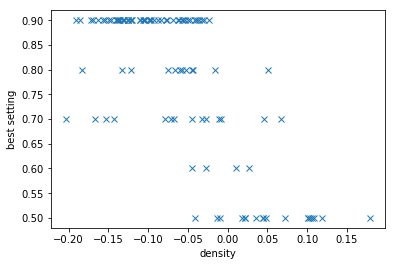

In [21]:
import matplotlib.pyplot as plt

plt.plot(data[:,2], best_settings, 'x')
plt.xlabel('density')
plt.ylabel('best setting')
plt.show()

In [14]:
os.chdir("C:\\Miniconda3\\Jupyter\\GHSOM_simplex_dsd\\parameter_tests_density\\0\\1")

nmi_scores = load_obj('nmi_scores')

print nmi_scores

[  0.00000000e+00   8.93502361e-01   8.94734085e-01  -2.77555756e-06
   8.93502361e-01   8.94734085e-01   0.00000000e+00   0.00000000e+00
  -2.77555756e-06  -2.77555756e-06]
